# The Simpsons

## Preparations

### Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [139]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import itertools
import glob
from sklearn import preprocessing, metrics

In [140]:
import warnings

#warnings.filterwarnings('ignore')

### Select Characters

Create a list of characters that we want to recognise

In [141]:
selected_characters = [
    "abraham_grampa_simpson",
    "agnes_skinner",
    "apu_nahasapeemapetilon",
    "barney_gumble",
    "bart_simpson",
    "carl_carlson",
    "charles_montgomery_burns",
    "chief_wiggum",
    "cletus_spuckler",
    "comic_book_guy",
    "disco_stu",
    "edna_krabappel",
    "fat_tony",
    "gil",
    "groundskeeper_willie",
    "homer_simpson",
    "kent_brockman",
    "krusty_the_clown",
    "lenny_leonard",
    "lisa_simpson",
    "maggie_simpson",
    "marge_simpson",
    "martin_prince",
    "mayor_quimby",
    "milhouse_van_houten",
    "miss_hoover",
    "moe_szyslak",
    "ned_flanders",
    "nelson_muntz",
    "otto_mann",
    "patty_bouvier",
    "principal_skinner",
    "professor_john_frink",
    "rainier_wolfcastle",
    "ralph_wiggum",
    "selma_bouvier",
    "sideshow_bob",
    "sideshow_mel",
    "simpsons_dataset",
    "snake_jailbird",
    "troy_mcclure",
    "waylon_smithers",
]

encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)

LabelEncoder()

### Directories

In [142]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Previewing the characters

ValueError: num must be 1 <= num <= 25, not 26

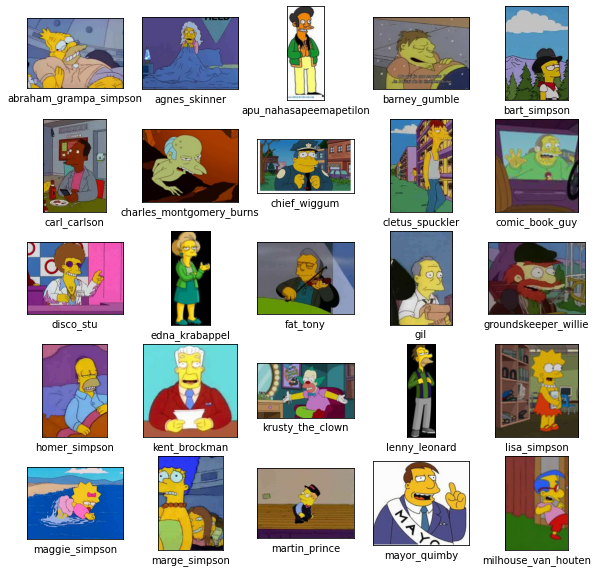

In [144]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
plt.show()

## Resizing Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [145]:
standard_resolution = 352
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

In [146]:
def get_resized_image(image_path):
    img = Image.open(image_path)
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)  #store im as numpy array
    # shape of image is ([128x(r,g,b)], [128x(r,g,b)])
    img = np.array(img)
    return img

ValueError: num must be 1 <= num <= 25, not 26

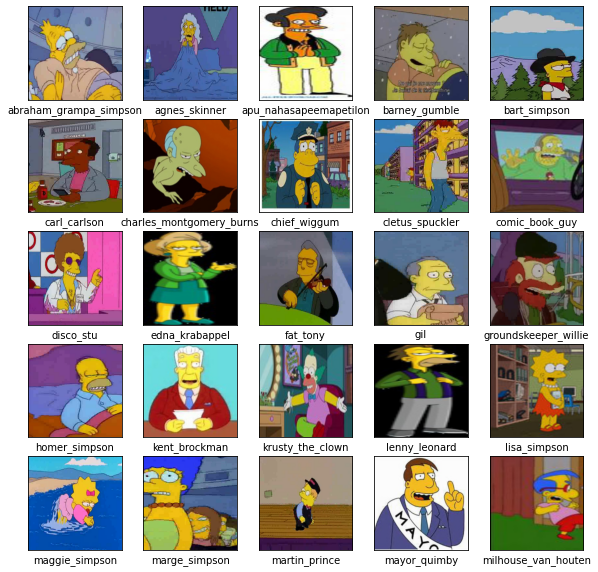

In [147]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(get_resized_image(directories["dataset"] + character_name + "/pic_0000.jpg"))
    plt.xlabel(character_name)
plt.show()

## Load files and split into test data

In [148]:
test_factor = 0.2  # determine what percentage of each character's images should be used for testing

In [149]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  #loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_test_count = round(current_character_picture_count * test_factor)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(
            current_character_paths_list):  #loop over all files ending in .jpg in the current folder
        print("[", current_image_position, "/", current_character_picture_count, "]" + current_character_picture_path,
              end='\r')

        current_character_picture = get_resized_image(current_character_picture_path)  # load picture

        if current_image_position <= current_character_test_count:  # if the current image is still part of the test part add to testing
            test_images.append(current_character_picture)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(current_character_picture)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:abraham_grampa_simpson (label number 0)

[ 912 / 913 ]./data/archive/simpsons_dataset/abraham_grampa_simpson/pic_0743.jpg
Loading Character:agnes_skinner (label number 1)

[ 41 / 42 ]./data/archive/simpsons_dataset/agnes_skinner/pic_0025.jpg
Loading Character:apu_nahasapeemapetilon (label number 2)

[ 622 / 623 ]./data/archive/simpsons_dataset/apu_nahasapeemapetilon/pic_0025.jpg
Loading Character:barney_gumble (label number 3)

[ 105 / 106 ]./data/archive/simpsons_dataset/barney_gumble/pic_0025.jpg
Loading Character:bart_simpson (label number 4)

[ 1341 / 1342 ]./data/archive/simpsons_dataset/bart_simpson/pic_0743.jpg
Loading Character:carl_carlson (label number 5)

[ 97 / 98 ]./data/archive/simpsons_dataset/carl_carlson/pic_0025.jpg
Loading Character:charles_montgomery_burns (label number 6)

7 / 1193 ]./data/archive/simpsons_dataset/charles_montgomery_burns/pic_0752.jpg[ 1010 / 1193 ]./data/archive/simpsons_dataset/charles_montgomery_burns/pic_0382.jpg[ 1059 / 1193 

In [150]:
training_images[0].shape

(352, 352, 3)

## Create Convolutional Neuronal Network

In [151]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(standard_resolution, standard_resolution, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(selected_characters))
])

In [152]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 352, 352, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 352, 352, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 176, 176, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 88, 88, 64)       

In [153]:
#from sklearn.preprocessing import LabelEncoder

#df[target_col] = LabelEncoder().fit_transform(df[target_col])

In [154]:
#training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
522/522 [==============================] - 372s 712ms/step - loss: 2.5338 - accuracy: 0.3476 - val_loss: 1.9354 - val_accuracy: 0.5000
Epoch 2/10
522/522 [==============================] - 364s 696ms/step - loss: 1.4318 - accuracy: 0.6197 - val_loss: 1.6477 - val_accuracy: 0.5812
Epoch 3/10
522/522 [==============================] - 354s 678ms/step - loss: 0.7557 - accuracy: 0.7924 - val_loss: 1.6386 - val_accuracy: 0.6178
Epoch 4/10
522/522 [==============================] - 354s 678ms/step - loss: 0.2784 - accuracy: 0.9224 - val_loss: 2.0628 - val_accuracy: 0.6342
Epoch 5/10
522/522 [==============================] - 349s 668ms/step - loss: 0.1080 - accuracy: 0.9691 - val_loss: 2.3127 - val_accuracy: 0.6261
Epoch 6/10
522/522 [==============================] - 352s 673ms/step - loss: 0.0669 - accuracy: 0.9807 - val_loss: 3.1684 - val_accuracy: 0.6223
Epoch 7/10
522/522 [==============================] - 361s 692ms/step - loss: 0.0491 - accuracy: 0.9873 - val_loss: 3.3469 -

## Visualise the Network

133/133 - 24s - loss: 3.3860 - accuracy: 0.6190 - 24s/epoch - 183ms/step


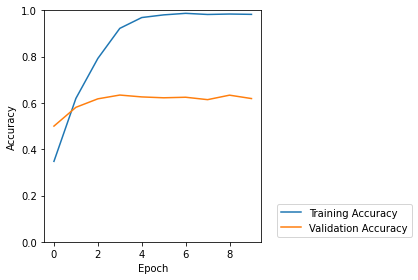

In [158]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

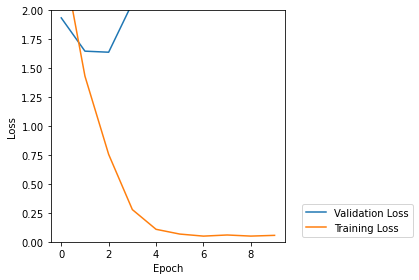

In [159]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

## Load the test dataset

In [160]:
def load_test_set():
    pics, labels = [], []
    for all_test_pictures in glob.glob(directories["testset"] + '*.jpg'):
        file_name = all_test_pictures.split("/")[
            -1]  # './data/archive/kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_34.jpg'
        character_name_with_number = file_name.split(".jpg")[-2]  # 'principal_skinner_34'
        character_name_clean = character_name_with_number.rsplit('_', 1)[0]  # 'principal_skinner'

        if character_name_clean in selected_characters:
            character_label = encoded_labels.transform([character_name_clean])
            temp = get_resized_image(all_test_pictures)
            pics.append(temp)
            labels.append(character_label)
    x_test = np.array(pics)
    y_test = np.array(labels)
    print("Test set", x_test.shape, y_test.shape)
    return x_test, y_test

In [161]:
x_test, y_test = load_test_set()
prediction = model.predict(x_test)

Test set (990, 352, 352, 3) (990, 1)


## Confusion Matrix

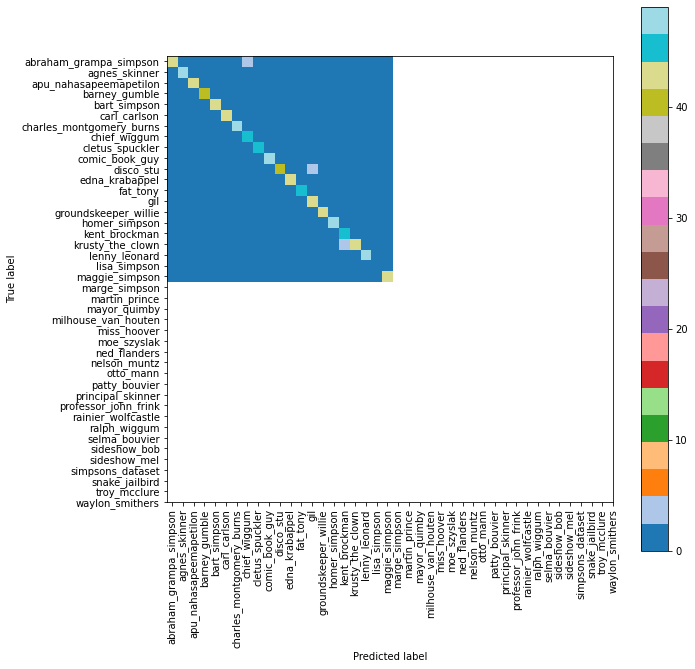

In [162]:
plt.figure(figsize=(10, 10))
labels = list(encoded_labels.classes_)
cm = metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
tick_marks = np.arange(len(labels))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20)
plt.colorbar()
_ = plt.xticks(tick_marks, labels, rotation=90)
_ = plt.yticks(tick_marks, labels)
plt.savefig("confusion_matrix.png", dpi=300)
#p = metrics.ConfusionMatrixDisplay(cm, display_labels=labels).plot()

## Simple Predictions

In [166]:
prediction_images = []

current_character_picture = get_resized_image(directories["testset"] + "bart_simpson_27.jpg")

#im = current_character_picture / 255.0
#img_array = tf.expand_dims(im, 0)  # Create a batch

img_array = tf.expand_dims(current_character_picture, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

#print(predictions[0])
#print(score)

#print(100 * np.max(score))

#print(np.argmax(predictions))
#print([labels[i] for i,prob in enumerate(predictions) if prob > 0.5])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
)

This image most likely belongs to bart_simpson with a 82.27 percent confidence.
